In [1]:
# step one, see how we did for our sims
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
import sciris as sc
sys.path.append('../../')
from fig1_calibration import create_sim as cs
bounds = cs.define_pars(which='bounds',use_safegraph=True)
bounds['tn'][0] = 5.0
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=False)
rc('grid', linestyle="--", color='black')

colors =['#374E55FF', '#DF8F44FF', '#00A1D5FF', '#B24745FF', '#79AF97FF', '#6A6599FF']
df_colors = pd.DataFrame({
    'color':colors
}).assign(wave=lambda x: x.index)

df_initial = pd.read_csv('../2024-07-03-sims_combined-tn-5.csv')
df_initial['wave'] = 0
df_sims    = pd.concat([
    pd.read_csv('../data/sims_combined-wave001.csv').assign(wave=1),
    pd.read_csv('../data/sims_combined-wave002.csv').assign(wave=2),
    pd.read_csv('../data/sims_combined-wave003.csv').assign(wave=3),
    pd.read_csv('../data/sims_combined-wave004.csv').assign(wave=4)
])
df = pd.concat(
    [df_initial,
     df_sims
      ]
)
keys = ['beta', 'bc_lf', 'tn', 'bc_wc1']
mapping = sc.objdict({
    'beta'  : r'Overall $\beta$',
    'bc_wc1': r'Work/community $\beta$ reduction',
    'bc_lf' : r'LTCF $\beta$ reduction',
    'tn'   : 'Symptomatic testing OR',
    })

Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


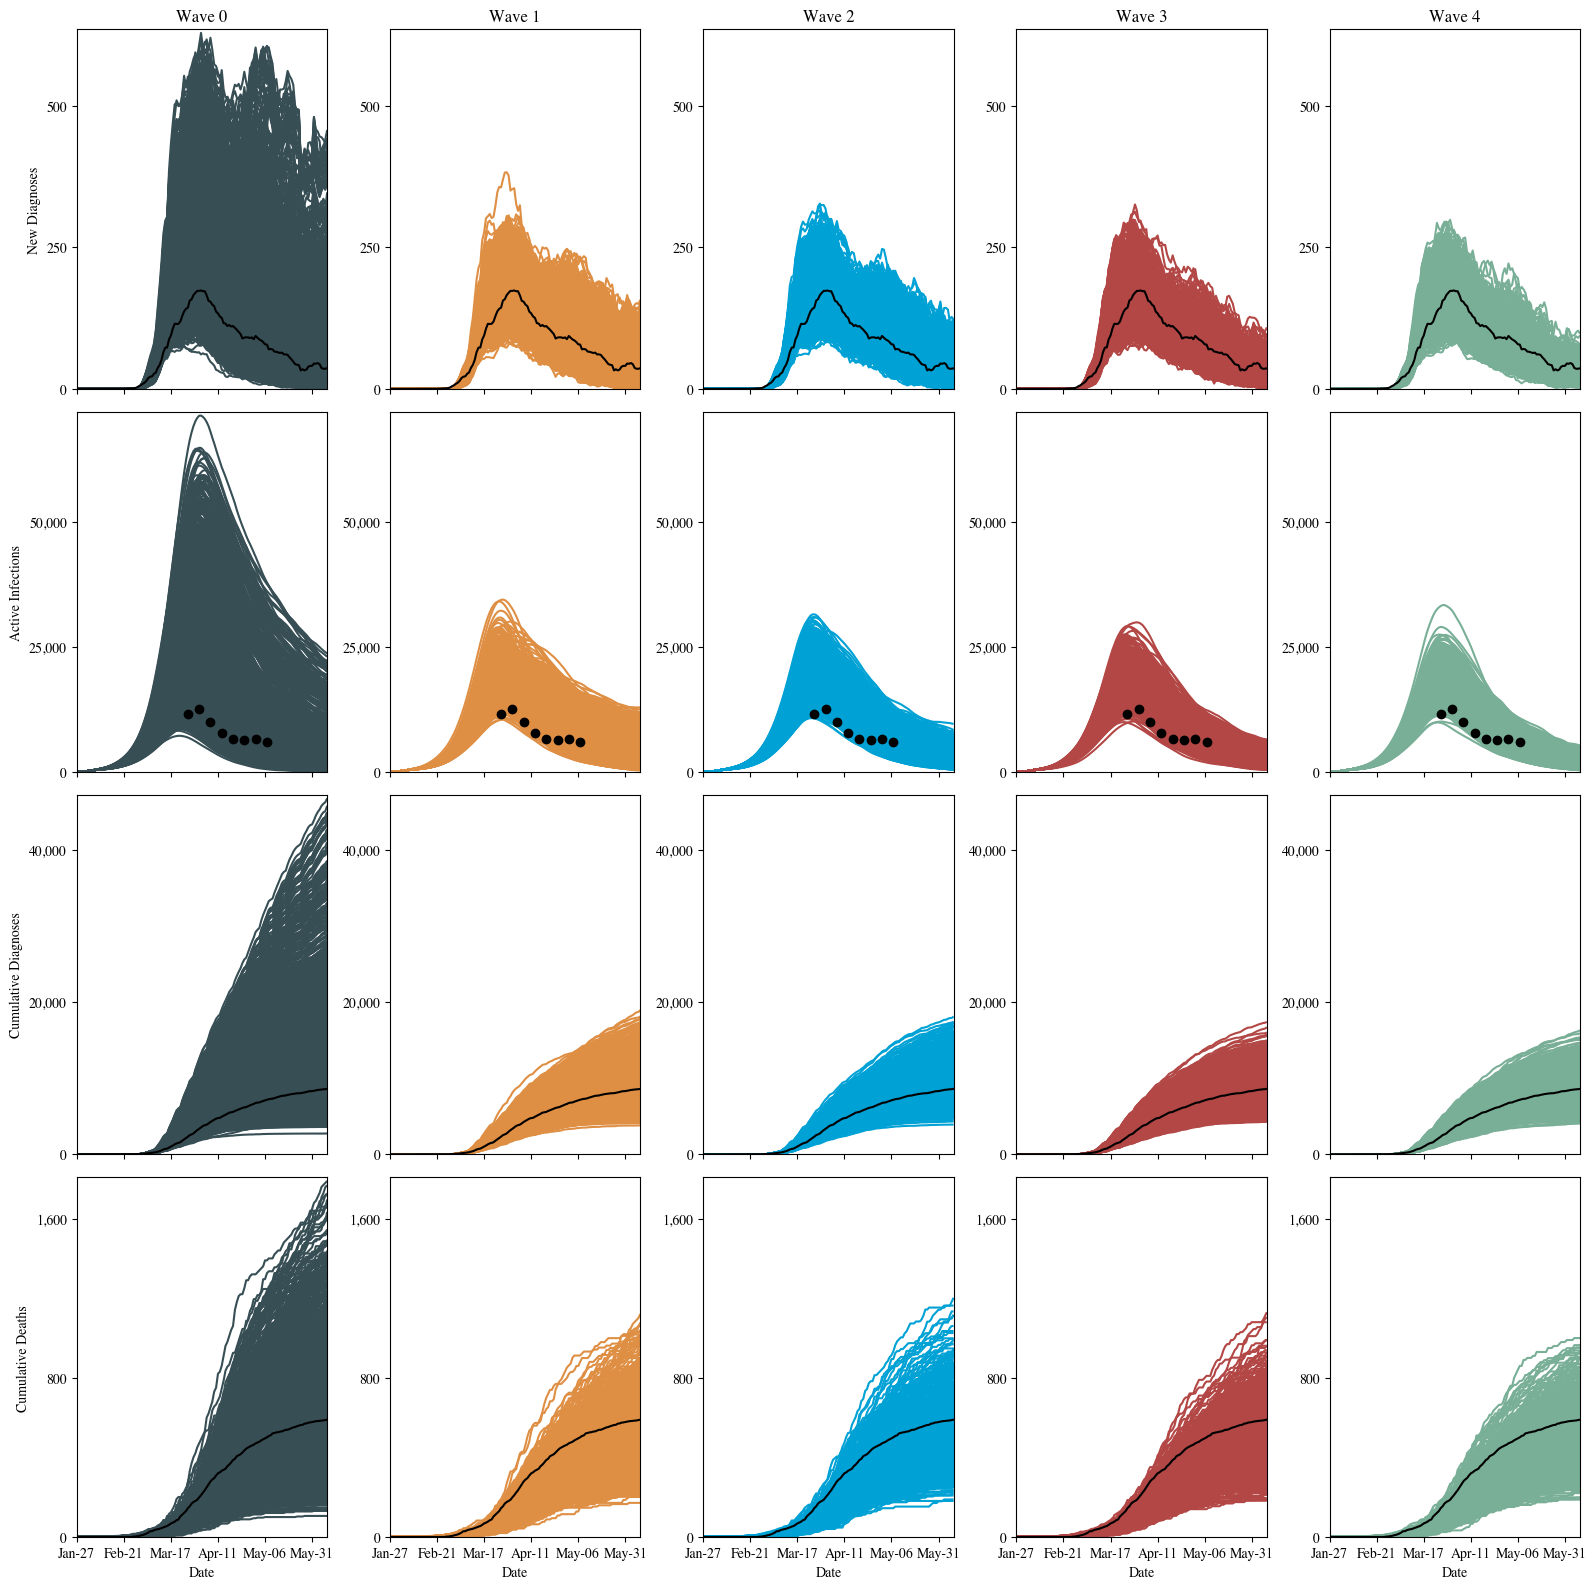

In [3]:
from matplotlib.collections import LineCollection
import matplotlib.ticker as ticker
import datetime as dt
start_day = pd.to_datetime('2020-01-27')
n_days = df_sims['t'].max() - df_sims['t'].min()
ymax = (1.01*df[['cum_deaths','cum_diagnoses','diagnoses','infectious']].max(axis=0)).to_dict()
def format_ax(ax):
    ''' Format the axes nicely '''
    @ticker.FuncFormatter
    def date_formatter(x, pos):
        return (start_day + dt.timedelta(days=x)).strftime('%b-%d')
    ax.xaxis.set_major_formatter(date_formatter)
    ax.set_xlim([0, n_days])
    ax.set_xlabel('Date')

    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    return
def make_collection(i,iter_wave,col,ax):
    ''' make a list of lines '''
    df_wave = df.query('wave==@iter_wave')
    wide = df_wave[['t',col,'rand_seed']].pivot(index='t',columns='rand_seed',values=col)
    lines = [np.hstack([wide.index.values.reshape(-1,1),wide[col].values.reshape(-1,1)]) for col in wide.columns]
    collection = LineCollection(lines,colors=colors[i])
    
    ax.set_xlim(0,df_wave['t'].max())
    ax.set_ylim(0,ymax[col])
    return collection

fig, ax = plt.subplots(nrows=4,ncols=5,figsize=(16,16),sharex=True)
for i, iter_wave in enumerate(df['wave'].unique()):
    df_wave = df.query('wave==@iter_wave')
    grouped = df_wave.groupby('rand_seed')

    for j,col in enumerate(['diagnoses','infectious','cum_diagnoses','cum_deaths']):
        ax[j,i].add_collection(make_collection(i,iter_wave,col,ax=ax[j,i]))
# add empirical data
data = df_wave.loc[df_wave['rand_seed']==df_wave['rand_seed'].max()]
for j in range(5):
    data.plot(x='t',y='diagnoses_data',color='black',legend=None, ax = ax[0,j])
    dd = data[data['infectious_data'].isna()==False]
    ax[1,j].scatter(dd.t,dd.infectious_data,color = 'black',zorder=10)
    data.plot(x='t',y='cum_diagnoses_data',color='black',legend=None, ax = ax[2,j])
    data.plot(x='t',y='cum_deaths_data',color='black',legend=None, ax = ax[3,j])

# labeling
ax[0,0].set_ylabel('New Diagnoses')
ax[1,0].set_ylabel('Active Infections')
ax[2,0].set_ylabel('Cumulative Diagnoses')
ax[3,0].set_ylabel('Cumulative Deaths')

for i in range(5):
    title = f'Wave {i}'
    ax[0,i].set_title(title)

for i in range(4):
    for j in range(5):
        format_ax(ax[i,j])


fig.tight_layout()

fig.savefig('../figs/history-matching-rounds-4x5.png',bbox_inches='tight',dpi=500)

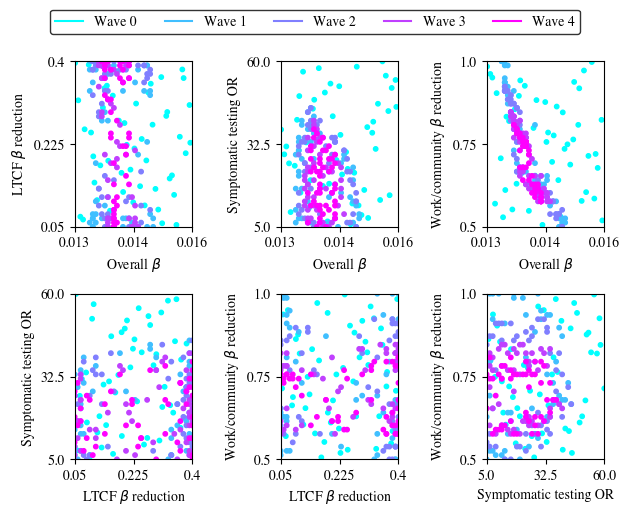

In [4]:
from itertools import combinations
import matplotlib as mpl
cmap = mpl.colormaps['cool']
pairs = list(combinations(keys,2))
designs = df.drop_duplicates(subset=keys)[keys + ['wave']].merge(df_colors,on='wave')
fig, ax = plt.subplots(nrows=2,ncols=3)
ax = ax.flatten()
cool_colors = cmap(np.linspace(0,1,designs['wave'].nunique()))

for i, pair in enumerate(pairs):
    x, y = pair
    ax[i].scatter(designs[x],designs[y],
                  c=designs['wave'],
                  cmap='cool',
                  #c=designs['color'],
                  s=10.0)
    nticks = 3
    xticks = np.linspace(bounds[x][0],bounds[x][1],nticks)
    yticks = np.linspace(bounds[y][0],bounds[y][1],nticks)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(np.round(xticks,3))
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(np.round(yticks,3))
    ax[i].set_xlabel(mapping[x])
    ax[i].set_xlim(bounds[x])
    ax[i].set_ylabel(mapping[y])
    ax[i].set_ylim(bounds[y])

fig.legend(
    [
        plt.plot([0], color=cool_colors[i])[0]
        for i in range(designs['wave'].nunique())
    ],
    [f"Wave {t}" for t in designs['wave'].unique()],
    bbox_to_anchor=(0.5, 1.0),
    loc="lower center",
    facecolor='white',
    edgecolor='black',
    ncol=designs['wave'].unique()
);

fig.tight_layout()
fig.savefig('../figs/wave-designs.pdf',bbox_inches='tight')